<center>
<img align="left" src="https://thumbs.dreamstime.com/b/casa-dos-desenhos-animados-para-venda-53745307.jpg" width="20%" height="20%">
<br>
<br>
<br>
<h1>House Prices: Advanced Regression Techniques</h1>
<h3>Kaggle Competition</h3>
</center>

In [329]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import skew
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.grid_search import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import seaborn as sns

<h2>Importing data from Kaggle</h2>

In [315]:
train = pd.DataFrame(pd.read_csv('train.csv'))
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [316]:
test = pd.DataFrame(pd.read_csv('test.csv'))
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


<h2>Cleaning Data</h2>

In [317]:
'''Number of elements null in each column'''
total_missing = train.isnull().sum()
total_missing

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [318]:
'''Select empty columns'''
to_delete = total_missing[total_missing>(train.shape[0]/3.)]
print(to_delete)

'''Delete empty columns'''
tables = [train,test]
for table in tables:
    table.drop(list(to_delete.index),axis=1,inplace=True)

Alley          1369
FireplaceQu     690
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64


<h2>Functions for prediction</h2>

In [319]:
def mean_squared_error_(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5
RMSE = make_scorer(mean_squared_error_, greater_is_better=False)

In [320]:
def data_preprocess(train,test):
    all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                          test.loc[:,'MSSubClass':'SaleCondition']))
    train["SalePrice"] = np.log1p(train["SalePrice"])
    numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
    all_data = pd.get_dummies(all_data)
    all_data = all_data.fillna(all_data.mean())
    X_train = all_data[:train.shape[0]]
    X_test = all_data[train.shape[0]:]
    y = train.SalePrice
    return X_train,X_test,y

In [321]:
def model_linear_regression(Xtrain,Xtest,ytrain):
    X_train = Xtrain
    y_train = ytrain
    etr = LinearRegression(n_jobs=1)
    param_grid = {}
    model = GridSearchCV(estimator=etr, param_grid=param_grid, n_jobs=1, cv=10, scoring=RMSE)
    model.fit(X_train, y_train)
    print('Best CV Score:')
    print(-model.best_score_)
    y_pred = model.predict(Xtest)
    return y_pred, -model.best_score_

In [322]:
def result(prediction,score):
    '''Create the .csv with id and predicted Sale Price for submission'''
    now = datetime.datetime.now()
    sub_file = 'submission_result.csv'
    pd.DataFrame({'Id': test['Id'].values, 'SalePrice': prediction}).to_csv(sub_file, index=False)

<h2>Running the Algoritm</h2>

In [323]:
Xtrain,Xtest,ytrain = data_preprocess(train,test)
test_predict, score = model_linear_regression(Xtrain,Xtest,ytrain)
result(np.exp(test_predict),score)

Best CV Score:
0.132625801251


In [324]:
predictData = pd.DataFrame(pd.read_csv('submission_result.csv'))
predictData.head()

,Id,SalePrice
0,1461,121685.498267
1,1462,156404.027208
2,1463,189623.029572
3,1464,200369.243448
4,1465,200366.170265


<h2>Stats</h2>


In [333]:
# plt.figure(figsize=(12,5))
# #f, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
# plt.subplot(121)
# sns.distplot(predictData['SalePrice'],kde=False)
# plt.xlabel('Sale price')
# plt.axis([0,800000,0,180])
# plt.subplot(122)
# sns.distplot(np.log(predictData['SalePrice']),kde=False)
# plt.xlabel('Log (sale price)')
# plt.axis([10,14,0,180])

[10, 14, 0, 180]

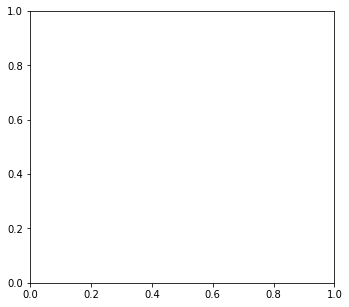

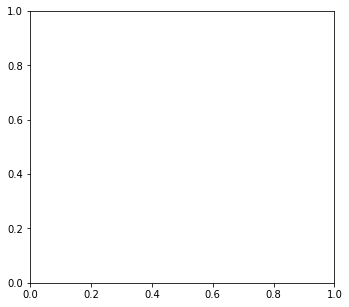

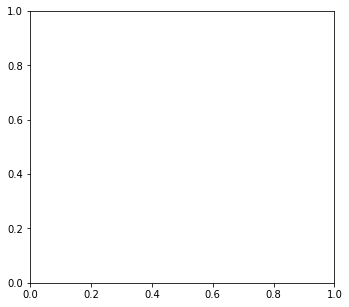

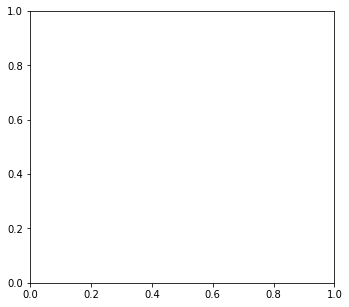

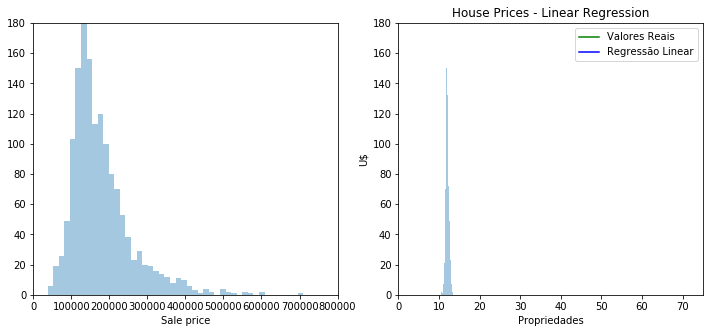

In [334]:
# #That chart makes any sense
# y_pred = predictData["SalePrice"]
# train_origin = pd.DataFrame(pd.read_csv('train.csv'))
# y_train = train_origin["SalePrice"]
# plt.title('House Prices - Linear Regression')
# plt.ylabel('U$')
# plt.xlabel(u'Propriedades')
# reg_val, = plt.plot(y_pred,color='b',label=u'Regressão Linear')
# true_val, = plt.plot(y_train,color='g', label='Valores Reais')
# plt.xlim([0,75])
# plt.legend(handles=[true_val,reg_val])
# plt.show()

<h2>Credits</h2>

https://github.com/Shitao/Kaggle-House-Prices-Advanced-Regression-Techniques<br>
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data